<a href="https://colab.research.google.com/github/dibadabir/Project1_A24/blob/main/Second_Model_(VGG_Versions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# Import Libraries
import os
import random
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras import backend as K

# Mounting Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Define the paths

In [ ]:
# Specify folders in Google Drive
cancerous_folder = "/content/drive/MyDrive/2nd Model/Cancerous_Lesions_Preprocessed"
noncancerous_folder = "/content/drive/MyDrive/2nd Model/Non_Cancerous_Lesions_Preprocessed"


# Verify that the folders exist
if not os.path.exists(cancerous_folder):
    raise FileNotFoundError(f"The folder '{cancerous_folder}' does not exist.")
if not os.path.exists(noncancerous_folder):
    raise FileNotFoundError(f"The folder '{noncancerous_folder}' does not exist.")

# Functions for Plotting the Evaluation Results

In [ ]:
#Plot Training and Validation Loss and Accuracy
def plot_training_history(history):
    """Plots the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))


    #Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    #Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


#Confusion Matrix for Predictions (FP, FN, TP, TN)
def plot_confusion_matrix(y_true, y_pred_classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NonCancerous", "Cancerous"], yticklabels=["NonCancerous", "Cancerous"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
def plot_roc_auc(y_true, y_pred):
    """Plots the ROC-AUC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # Calculate False Positive Rate and True Positive Rate
    roc_auc = auc(fpr, tpr)  # Calculate AUC


    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


#Classification Report - Precision, Recall, F1-score and Support
def generate_classification_report(y_true, y_pred_classes):
    """Generates a classification report."""
    report = classification_report(y_true, y_pred_classes, target_names=["NonCancerous", "Cancerous"])
    print("\nClassification Report:\n")
    print(report)

# Load Images

In [ ]:
# Load and organize images
def load_images_from_folder(folder, label):
    return [(os.path.join(folder, img), label) for img in os.listdir(folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

# Load all images and assign labels
cancerous_images = load_images_from_folder(cancerous_folder, 'Cancerous')
noncancerous_images = load_images_from_folder(noncancerous_folder, 'NonCancerous')

# Combine all images and labels
all_images = cancerous_images + noncancerous_images
random.seed(42)
random.shuffle(all_images)

# Split the data
image_paths, labels = zip(*all_images)
labels = np.array([1 if label == 'Cancerous' else 0 for label in labels])

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Version 1

In [ ]:
# Create datasets
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)  # VGG16 preprocessing
    return image, label

def load_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the VGG16 model
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Compile the model
model = create_vgg16_model()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Class Weights (handle class imbalance)
class_weights = {0: 1.0, 1: 3.0}

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Save the model
model_save_path = '/content/drive/MyDrive/skin_classification_vgg16_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - accuracy: 0.5274 - loss: 2.3333 - val_accuracy: 0.5725 - val_loss: 1.1824 - learning_rate: 1.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step - accuracy: 0.5491 - loss: 2.0463 - val_accuracy: 0.6075 - val_loss: 1.1337 - learning_rate: 1.0000e-04
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.5905 - loss: 1.7250 - val_accuracy: 0.6475 - val_loss: 1.0782 - learning_rate: 1.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.6029 - loss: 1.6406 - val_accuracy: 0.6650 - val_loss: 1.0267 - learning_rate: 1.0000e-04
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 215ms/step - accuracy: 0.6195 - loss: 1.4610 - val_accuracy: 0.6125 - val_loss: 1.1020 - learning_rate: 1.0000e-04
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.6483 - loss: 1.4051 - val_accuracy: 0.6350 - val_loss: 1.0369 - learning_rate: 1.0000e-04
Epoch 7/1


Test accuracy: 0.74

Model saved to: /content/drive/MyDrive/skin_classification_vgg16_model.h5


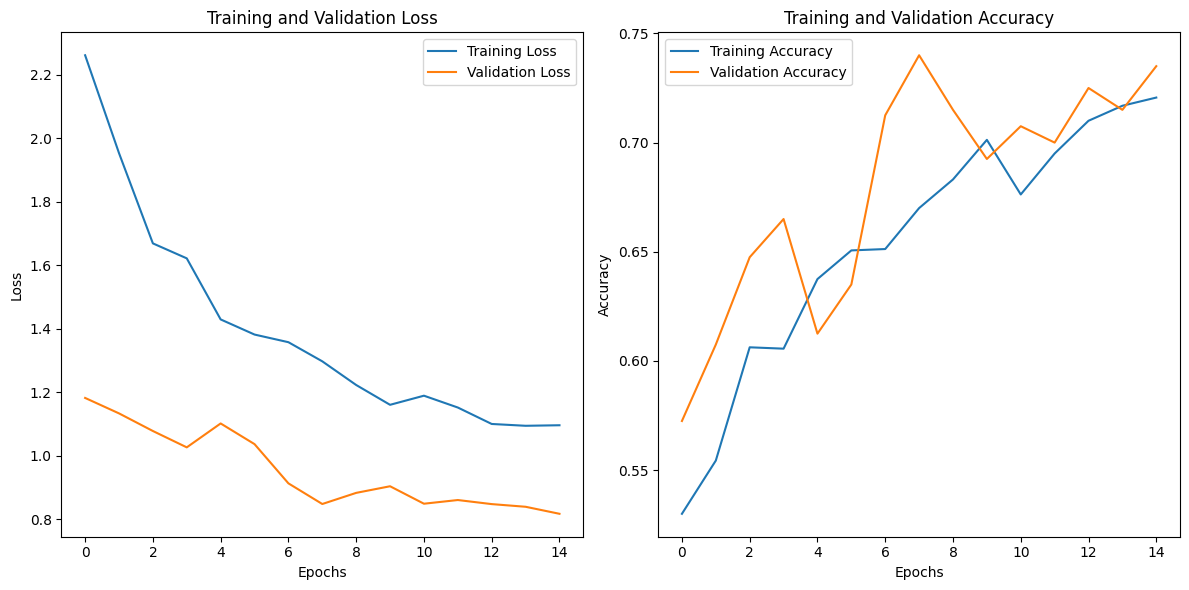

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step


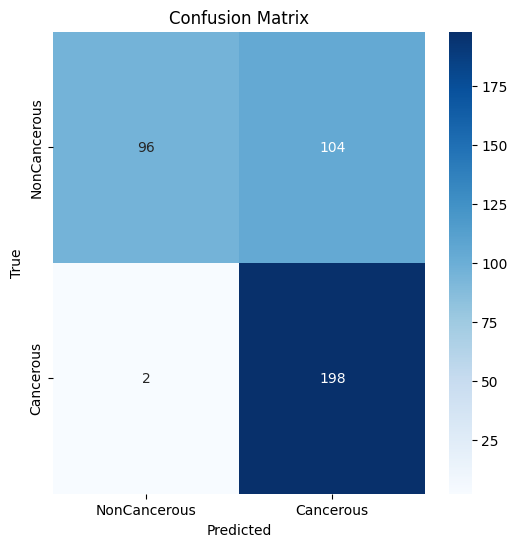

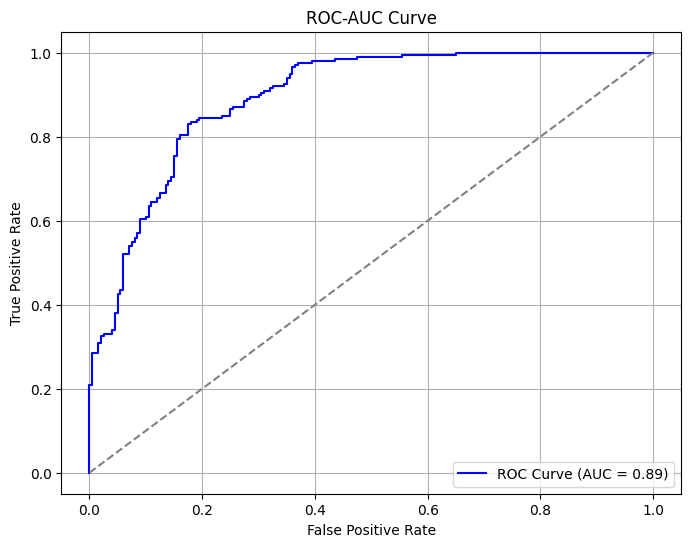


Classification Report:

              precision    recall  f1-score   support

NonCancerous       0.98      0.48      0.64       200
   Cancerous       0.66      0.99      0.79       200

    accuracy                           0.73       400
   macro avg       0.82      0.73      0.72       400
weighted avg       0.82      0.73      0.72       400



In [ ]:
#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)
plot_confusion_matrix(y_true, y_pred_classes)


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
generate_classification_report(y_true, y_pred_classes)

# Version 2

changes:

*   Using Focal Loss instead of Binary Cross-Entropy
*   Threshold tuning using ROC curve



In [ ]:
!pip install tensorflow==2.13.0 # Update TensorFlow to the version that includes the needed method
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

# Data Preprocessing with Augmentation
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    # Data Augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    image = preprocess_input(image)  # VGG16 preprocessing
    return image, label

def load_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy='auto')
X_train_balanced, y_train_balanced = smote.fit_resample(np.array(X_train), np.array(y_train))

train_dataset = load_data(X_train_balanced, y_train_balanced).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the Model using VGG16
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze all layers for fine-tuning
    for layer in base_model.layers[:-4]:
        layer.trainable = False  # Freeze all but the top 4 layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Learning Rate Scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Compile the Model
model = create_model()
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the Model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the Model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Predict and Generate Classification Report
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype('int32')
print(classification_report(y_test, y_pred_classes))

# Save the Model
model_save_path = '/content/drive/MyDrive/skin_classification_vgg16_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


ImportError: cannot import name 'preprocess_input' from 'tensorflow.keras.applications' (/usr/local/lib/python3.11/dist-packages/keras/api/_v2/keras/applications/__init__.py)

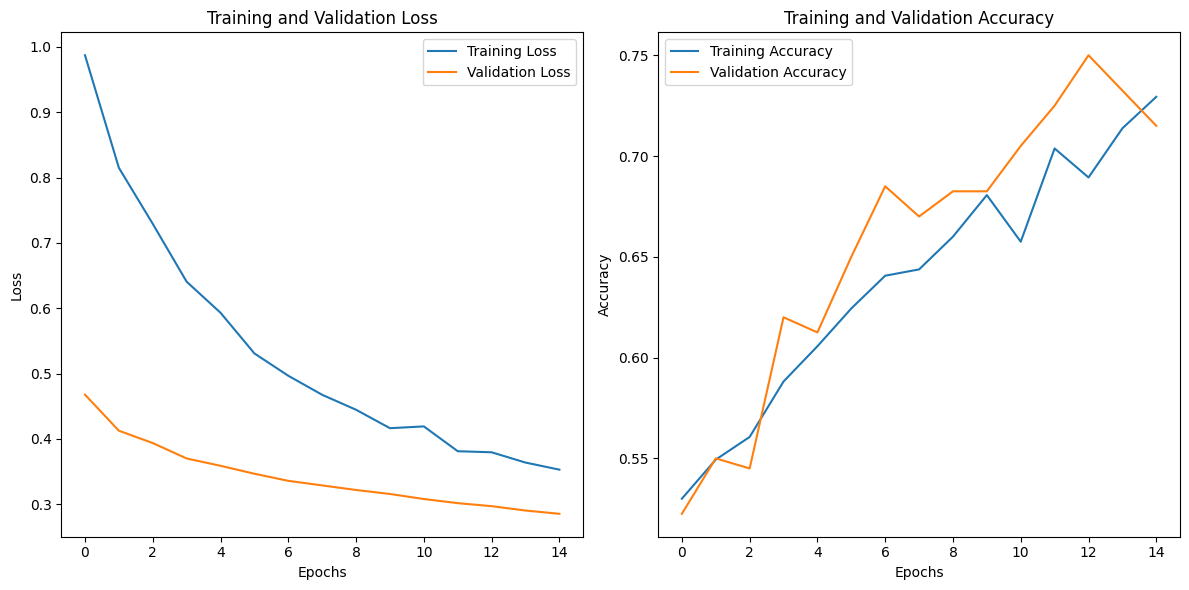

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step


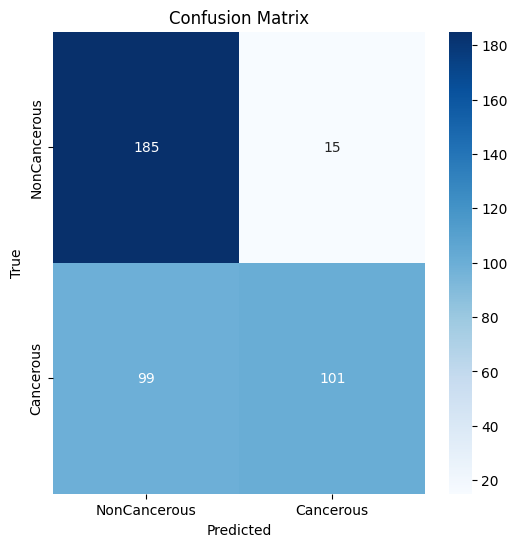

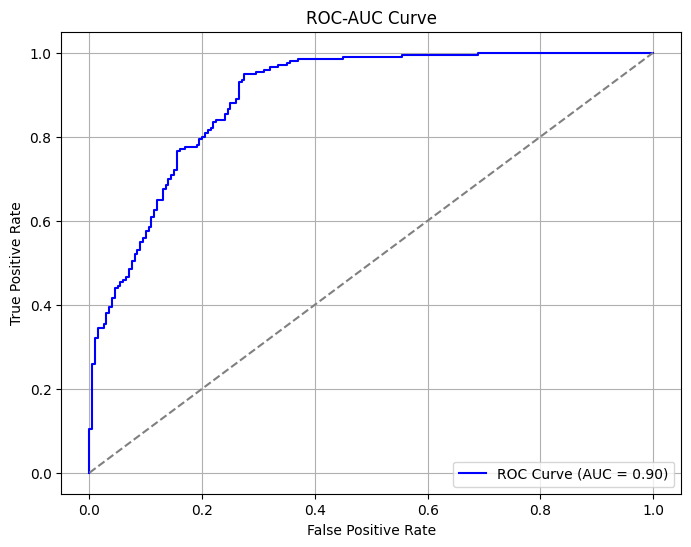


Classification Report:

              precision    recall  f1-score   support

NonCancerous       0.65      0.93      0.76       200
   Cancerous       0.87      0.51      0.64       200

    accuracy                           0.71       400
   macro avg       0.76      0.72      0.70       400
weighted avg       0.76      0.71      0.70       400



In [ ]:
#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)
plot_confusion_matrix(y_true, y_pred_classes)


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
generate_classification_report(y_true, y_pred_classes)

# Version 3

changes:

*   Data Augmentation
*   Fine Tuning
*   Increase the Model Capacity
*   Learning Rate Scheduler
*   Class Imbalance
*   Using AdamW optimizer instead of Adam

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create datasets
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    # Advanced Data Augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image) if tf.random.uniform([]) > 0.5 else image  # Random 90-degree rotation
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop

    image = preprocess_input(image)  # VGG16 preprocessing
    return image

def load_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the VGG16 model
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last 20 layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.003)),  # Stronger L2 Regularization
        layers.Dropout(0.7),  # Increased Dropout
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Define Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# Compile the model
model = create_vgg16_model()
model.compile(optimizer=AdamW(learning_rate=0.00005, clipnorm=1.0),
              loss=focal_loss(alpha=0.25, gamma=2.0),
              metrics=['accuracy'])

# Class Weights (handle class imbalance)
class_weights = {0: 1.0, 1: 4.0}

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Save the model
model_save_path = '/content/drive/MyDrive/skin_classification_vgg16_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 595ms/step - accuracy: 0.5197 - loss: 1.6256 - val_accuracy: 0.5250 - val_loss: 1.0235 - learning_rate: 5.0000e-05
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.5495 - loss: 1.1168 - val_accuracy: 0.5000 - val_loss: 0.9544 - learning_rate: 5.0000e-05
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 571ms/step - accuracy: 0.5548 - loss: 1.0348 - val_accuracy: 0.5000 - val_loss: 0.8931 - learning_rate: 5.0000e-05
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 501ms/step - accuracy: 0.5295 - loss: 0.9740 - val_accuracy: 0.5000 - val_loss: 0.8306 - learning_rate: 5.0000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 510ms/step - accuracy: 0.5105 - loss: 0.9076 - val_accuracy: 0.5000 - val_loss: 0.7708 - learning_rate: 5.0000e-05
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.5103 - loss: 0.8537 - val_accuracy: 0.5000 - val_loss: 0.7196 - learning_rate: 5.0000e-05
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 517ms/step - acc


Test accuracy: 0.68

Model saved to: /content/drive/MyDrive/skin_classification_vgg16_model.h5


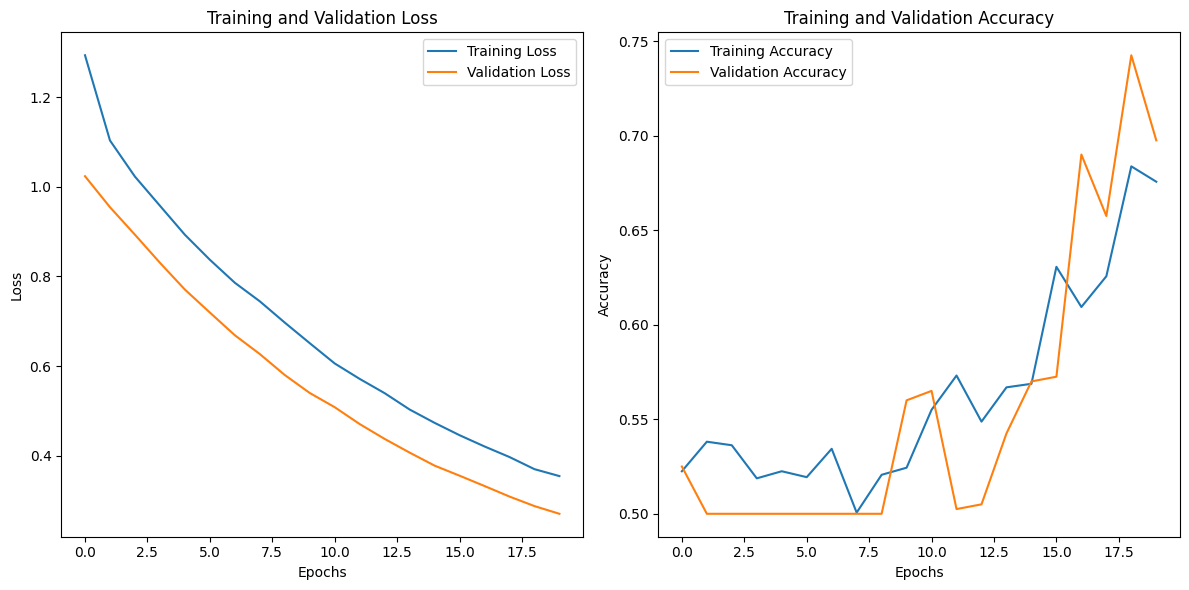

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


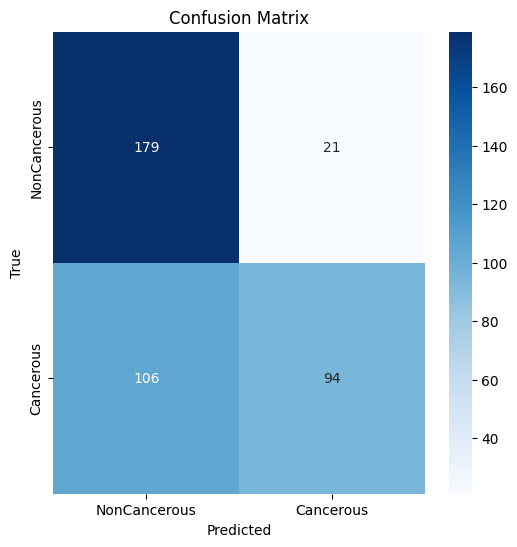

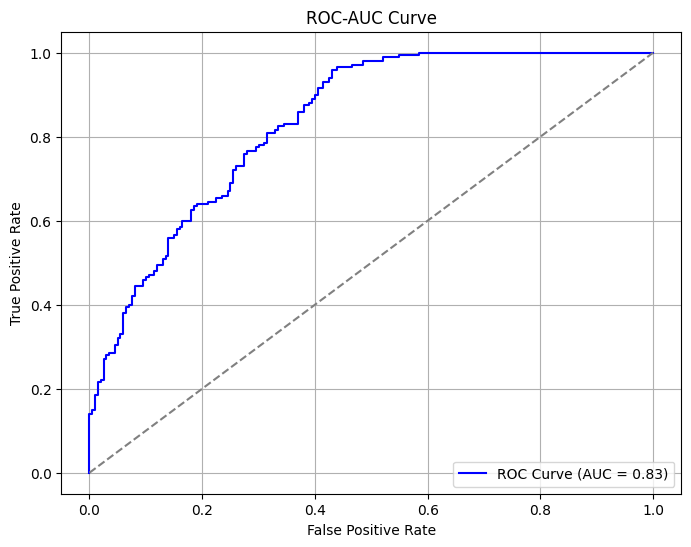


Classification Report:

              precision    recall  f1-score   support

NonCancerous       0.63      0.90      0.74       200
   Cancerous       0.82      0.47      0.60       200

    accuracy                           0.68       400
   macro avg       0.72      0.68      0.67       400
weighted avg       0.72      0.68      0.67       400



In [ ]:
#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)
plot_confusion_matrix(y_true, y_pred_classes)


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
generate_classification_report(y_true, y_pred_classes)